In [1]:
from py2neo import Graph,Relationship,Node
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
graph = Graph("bolt://localhost:7687",password='azeem0786')

In [3]:
G=graph.run('match (n) return n.name as name,n.sum as formula;').data()
#F=graph.run('match (n) return n.sum as sum').data()

In [7]:
G

[{'name': 'Rate', 'formula': None},
 {'name': 'Quantity', 'formula': None},
 {'name': 'Amount', 'formula': None},
 {'name': 'Discount Per', 'formula': None},
 {'name': 'Discount Amount', 'formula': None},
 {'name': 'Net Amount', 'formula': None}]

In [37]:
D={x['name']:None for x in G}

In [38]:
D

{'Rate': None,
 'Quantity': None,
 'Amount': None,
 'Discount Per': None,
 'Discount Amt': None,
 'Net Amount': None}

In [39]:
f={x['name']:x['formula'] for x in G}

In [40]:
f

{'Rate': None,
 'Quantity': None,
 'Amount': 'Rate*Quantity',
 'Discount Per': None,
 'Discount Amt': 'Discount Per*Amount',
 'Net Amount': 'Amount-Discount Amt'}

In [41]:
inpNodes=[x for x,y in f.items() if y ==None]
derNodes=[x for x,y in f.items() if y !=None]

In [42]:
inpNodes

['Rate', 'Quantity', 'Discount Per']

In [43]:
derNodes

['Amount', 'Discount Amt', 'Net Amount']

In [20]:
for i in inpNodes:
    D[i] = int(input("enter the"+i+": "))

for d in derNodes:
    formula=f[d]
    for i in inpNodes:
        formula=formula.replace(i,"D['%s']"%i)
        
    print(formula)
    
    D[d]=eval(formula)

D['Rate']*Quantity
D['Rate']*D['Quantity']
D['Rate']*D['Quantity']
6
Discount Per*Amount
Discount Per*Amount
D['Discount Per']*Amount


NameError: name 'Amount' is not defined

In [13]:
D

{'Rate': 3,
 'Quantity': 2,
 'Amount': 6,
 'Discount Per': 5,
 'Discount Amt': None,
 'Net Amount': None}

In [65]:
% %cypher
MATCH(Price)-[Linked]->(Total)
MATCH(Number)-[Linked]->(Total)
RETURN Price.name,Total.name,Number.name

SyntaxError: invalid syntax (<ipython-input-65-5569f6b1e68a>, line 2)

In [ ]:
#step-7 Getting rate,quantity and discount per(in decimal value) from the user... 
for i in inpNodes:
    nodeName[i] = float(input("enter the " +i+ ":"))
        
for d in derNodes:
    formula = nodeProperty[d]
    if formula == "Rate*Quantity":
        for i in inpNodes:
            formula = formula.replace(i,"nodeName['%s']"%i)  #replacing the Rate*Quantity into nodeName['Rate']*nodeName['Quantity']    
        print(formula)
        nodeName[d] = eval(formula) #evalauting the string expression using eval() ...
        continue
    elif formula == "Discount Per*Amount":
        for i in inpNodes:
            formula = formula.replace(i,"nodeName['%s']"%i)
        for j in derNodes:
            formula = formula.replace(j,"nodeName['%s']"%j)
        print(formula)
        nodeName[d] = eval(formula)
        continue
    elif formula == "Amount-Discount Amount":
        nodeName['Net Amount'] = nodeName['Amount']-nodeName['Discount Amount']
        print(formula)

In [27]:
def DeriveTo(graph,Nodes):
    "returns the nodes to which the list of nodes passed is used for derivation"
    derives=[]
    for l in Nodes:
        try:
            adj=list(graph.adj[l])
        except KeyError:
            print("no adjacent nodes:",l)
            continue
        for i in adj:
            if pd.isnull(graph[l][i]["derive"])==False:
                derives.append(i) 
    return derives;
    
def SeqDerived(graph):
    "Order the Derived nodes based on its relationship"
    From=[x for x,y,v in graph.edges.data("derive") if pd.isnull(v)==False]
    To=[y for x,y,v in graph.edges.data("derive") if pd.isnull(v)==False]
    Input=[x for x in From if x not in To] 
    
    derList=deepcopy(Input)
    while len(Input)!=0:
        Input=DeriveTo(graph=graph,Nodes=Input)
        derList+=Input 
    
    drvOrdered=[derList[x] for x in range(len(derList)) if derList[x] not in derList[x+1:] and pd.isnull(graph.nodes[derList[x]]["DERIVE"])==False ]
    return drvOrdered;

In [7]:
def BaseGraph(tenantID,processCode,neo4j,mongo=None):
    "returns basegraph of processCode and tenant id passed."
    if pd.isnull(neo4j)==False:
        products=neo4j.run("match (b:PRODUCT) return filter(x in labels(b) where x<> \"PRODUCT\") as LAB;").data()
        products=[x["LAB"][0] for x in products]
        baseGraph=neo4j.run("match (a{process_code:{x}})-[r]->(b{process_code:{x}}) \
                        return a.name as Node,a.domain as DMn, r.assign as REl,\
                        r.derive_type as RDer,r.c_mandatory as Cmd,r.ConditionalMandatory as CondMand,\
                        r.c_mand_equality as Equality,\
                        a.default_value as DEf,a.derive as DErive,a.deriveby as DeriveBy,a.mandatory as MAnd,\
                        a.key as KEys,a.encode as ENcode,a.data_type as DTP,a.decimals as Decimal,a.predefined_list as PreDef,\
                        b.name as PArent,a.short_text as SHort,\
                        labels(a) as Section;",x=processCode).to_data_frame()                        
    else:
        bgMongo=mongo["Knowledge Graph"].find_one({"Tenant_ID":tenantID,"Document_Type":"BaseGraph","ProcessCode":processCode})
        if pd.isnull(bgMongo)==True:
            raise Exception("Knowledge Graph not installed.")
        products=bgMongo["Products"]
        baseGraph=pd.read_json(bgMongo["Document"])
        baseGraph = baseGraph.where(pd.notnull(baseGraph), None)
    
    
    gBase=nx.DiGraph(name=processCode)# creating basegraph
    for i in range(len(baseGraph)):
        a=baseGraph["Node"][i]
        b=baseGraph["PArent"][i]
        r=baseGraph.REl[i]
        der=baseGraph.RDer[i]
        cMand=baseGraph.Cmd[i]
        condMand=baseGraph.CondMand[i]
        equality=baseGraph.Equality[i]
        deriveBy=baseGraph.DeriveBy[i]
        gBase.add_edge(a,b,assign=r,derive=der,c_mandatory=cMand,
        condMand=condMand,equality=equality)
        gBase.nodes[a]["DEFAULT"]=baseGraph["DEf"][i]
        gBase.nodes[a]["DATATYPE"]=baseGraph["DTP"][i]
        gBase.nodes[a]["DECIMALS"]=baseGraph["Decimal"][i]
        if pd.isnull(deriveBy)==False and deriveBy=="FE":
            gBase.nodes[a]['DERIVE']=None 
        else:
            gBase.nodes[a]['DERIVE']=baseGraph["DErive"][i]   
        gBase.nodes[a]['name']=a
        gBase.nodes[a]["DOMAIN"]=baseGraph["DMn"][i]    
        gBase.nodes[a]["SHORT"]=baseGraph["SHort"][i]
        if pd.isnull(baseGraph["PreDef"][i])==False:
#             if baseGraph["PreDef"][i]=="GETPREDEF(TENANTID,GROUP_COMPANY,COMPANY)":
#                 predList=GETPREDEF(neo4j=neo4j,tenantID=tenantID)
#                 predList=[x.lower() for x in predList]
#             else:
            predList=baseGraph["PreDef"][i].lower()
            predList=predList.split(",")
            predList=[x.strip() for x in predList]
        else:
            predList=[]            
        gBase.nodes[a]["DEFINED"]=predList
        sect=[x for x in baseGraph["Section"][i] if x not in products]
        gBase.nodes[a]["SECTION"]=sect[0]
        gBase.nodes[a]["MANDATORY"]=baseGraph["MAnd"][i]
        if pd.isnull(baseGraph["KEys"][i])==True:
            pass
        else:
            gBase.nodes[a]["KEY"]=str(baseGraph["KEys"][i]).replace(".0","")
            gBase.nodes[a]["ENCODE"]=baseGraph["ENcode"][i]
    return gBase;


In [15]:
mongoIP="3.132.139.188"
mongoPass="123456"
neo4jPass="0ne1ntegral"
neo4jIP="3.132.139.188"

def DataBases(tenantID):
    "Returns neo4j and mongodb databases used for various modeof processing"
    
    # if os.path.exists(jsonPath)==False:
    #     if env=="server":
    #         configuration={"mongo":{"ip":"127.0.0.1","password":'123456'},
    #         "neo4j":{"ip":"127.0.0.1","password":'0ne1ntegral'}}
    #     else:
    #         #configuration={"mongo":{"ip":"3.132.139.188","password":"123456"}}
    #         configuration={"mongo":{"ip":"3.132.139.188","password":'123456'},
    #         "neo4j":{"ip":"3.132.139.188","password":'0ne1ntegral'}}

    # else:
    #     print("configuration file found..")
    #     jsonObj=open(jsonPath,'r')
    #     configuration=json.load(jsonObj)
#     if tenantID in ["AB00003","AB00004"]:
#         dbStorage=boto3.client("dynamodb",region_name="us-east-2")
#     else:
#         mongoDb=MongoClient("mongodb://OI:%s@%s/mydb"%(mongoPass,mongoIP))
#         dbStorage=mongoDb.mydb
    dbStorage=None
    if pd.isnull(neo4jIP)==False:
        neo4j=Graph("bolt://%s:7687"%neo4jIP,password=neo4jPass)
    else:
        neo4j=None
    
    return neo4j,dbStorage;

In [16]:
neo4j,db=DataBases(tenantID='AB00002')

In [17]:
neo4j

Graph('bolt://neo4j@3.132.139.188:7687')

In [18]:
gFAA=BaseGraph(processCode='FAA',tenantID='NA00002',neo4j=neo4j)

None


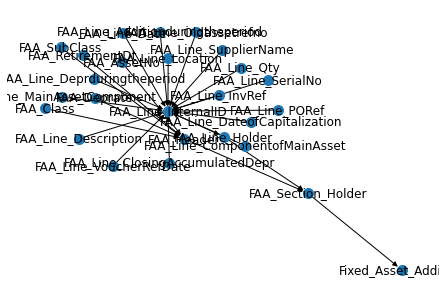

In [25]:
nx.draw(gFAA,with_labels=True,node_size=100)  # networkx draw()
print(plt.draw()) 

In [24]:
def FillProp(graph,prop):
    "Fills those nodes which doesnt contain the passed property with None"
    for node in list(graph.nodes()):
        for p in prop:
            if p not in graph.nodes[node].keys():
                graph.nodes[node][p]=None
    return graph;

In [29]:
gLease=FillProp(graph=gLease,prop=['DERIVE'])

NameError: name 'gLease' is not defined

In [30]:
deriveNodes=SeqDerived(graph=gLease)

NameError: name 'gLease' is not defined

In [22]:
deriveNodes

NameError: name 'deriveNodes' is not defined

In [23]:
gFAA.edges()

OutEdgeView([('FAA_Section_Holder', 'Fixed_Asset_Addition'), ('FAA_Header', 'FAA_Section_Holder'), ('FAA_AssetNo', 'FAA_Header'), ('FAA_Deprate', 'FAA_Header'), ('FAA_RetirementDt', 'FAA_Header'), ('FAA_Class', 'FAA_Header'), ('FAA_SubClass', 'FAA_Header'), ('FAA_Line_Holder', 'FAA_Section_Holder'), ('FAA_Line_InternalID', 'FAA_Line_Holder'), ('FAA_Line_VoucherRefDate', 'FAA_Line_InternalID'), ('FAA_Line_Description', 'FAA_Line_InternalID'), ('FAA_Line_Location', 'FAA_Line_InternalID'), ('FAA_Line_SerialNo', 'FAA_Line_InternalID'), ('FAA_Line_MainAssetComponent', 'FAA_Line_InternalID'), ('FAA_Line_ComponentofMainAsset', 'FAA_Line_InternalID'), ('FAA_Line_PORef', 'FAA_Line_InternalID'), ('FAA_Line_InvRef', 'FAA_Line_InternalID'), ('FAA_Line_SupplierName', 'FAA_Line_InternalID'), ('FAA_Line_Oldassetrefno', 'FAA_Line_InternalID'), ('FAA_Line_Qty', 'FAA_Line_InternalID'), ('FAA_Line_Additionduringtheperiod', 'FAA_Line_InternalID'), ('FAA_Line_DateofCapitalization', 'FAA_Line_InternalID'), 

In [ ]:
def GetKey(val):
    for i in range(len(relation)):
        for key,value in relation[i].items():
            if val == value:
                return key
loop=0

while loop<3:
    for i in range(len(relation)):        
        for deriveNodes in list(relation[i].values()):
            if deriveNodes not in availableNodes and GetKey(val=deriveNodes) in availableNodes :
                availableNodes.append(deriveNodes)
                
                if "Not Ok" in derive:
                    derive.clear()
                    break
            elif DeriveNodes == deriveNodes and GetKey(val=deriveNodes) in availableNodes:
                derive.append("Ok")
            elif DeriveNodes != deriveNodes:
                derive.append("NA")

        if "Ok" and "NA" not in derive: 
            continue
        else:
            availableNodes.append(deriveNodes)    